Cryptography

### Team
<ol>
    <li> Mark Pearson </li>
    <li> Ronan Geraghty</li>
    <li> Milan Patel </li>
    <li> Will Steynor </li>
</ol>



In [1]:
from NumberFunctions import *
import numpy as np
import random as ran
import matplotlib.pyplot as plt
from time import process_time
import pandas as pd
import numba
import time

Stuff extra to include

+ difference between asymmetric and symmetric cryptography

+ Steganography

# Core 2: RSA Signature Message

## Modular Inverse

Solve, 
> $ax = 1 \pmod{m} $ for  $x \in \{1,2,3,...,m-1\}$


Proof

We have, where $x,y \in \mathbb{Z}$ are calculated by the Euclidean algorithm.
> $ax+by = gcd(a,b)$

We only need to take into account when $gcd(a,b)=1$ as $e$ is chosen so $gcd(e,\phi{N})=1$

Let $m=b$, where $gcd(a,m) = 1$

So we get
> \begin{align*}
ax+my &= 1\\
ax + my &\equiv 1\pmod{m}\\
ax &\equiv 1\pmod{m}
\end{align*}

Therefore, $x$ is a modular inverse of $a$ for $m$

However, by using the Euclidean algorithm sometimes $x$ is not in the set $\{1,2,...,m-1\}$. This is a problem as if $x$ is negative when we use it later for the RSA signature we need to take the modulo of $int^{x}$, to do this we must have $int = int^{x}$

Let us consider the case where $x \notin \{1,2,...,m-1\}$, Let $d \in \mathbb{Z}$
> \begin{align*}
ax &\equiv 1\pmod{m}\\
ax + adm &\equiv 1\pmod{m}\\
a(x + dm) &\equiv 1\pmod{m}
\end{align*}

Set $x\prime = x + dm \iff x\prime = x \pmod{m}$

We know $x\prime \in \{1,2,...,m-1\}$


In [2]:
@numba.jit('int64(int64)', nopython=True)
def totient_fast(n):
    '''return the totient of n,
        number of postive integers < n which are coprime to n.'''
    num = 0
    for i in range(1, n):
        if gcd_fast(i, n) == 1:
            num += 1
    return num

@numba.vectorize('int64(int64)', nopython= True, target='parallel')
def totient_fast_ufunc_par(n):
    return totient_fast(n)

def totient(n):
    '''return the totient of n,
        number of postive integers < n which are coprime to n.'''
    num = 0
    for i in range(1, n):
        if gcd_fast(i, n) == 1:
            num += 1
    return num




def my_hash(message, N):
    '''Turn message to bits
    Then turn into int h'''
    return hash(message) % N


def modular_inverse(a, n):
    '''Solves ax = 1 mod(n) for x in {1,2,3,...,m-1}'''
    gcd, x, y = gcd_ext(a, n)
    if gcd == 1:
        return x % n
    else:
        return "gcd not = 1"

def get_primes_composites(n, is_prime_FUN=isprime_basic):
    '''returns a numpy array of primes and composites with largest number being n,
    is_prime_FUN: which function will be used to identify if a number is prime'''
    primes = []
    composites = []

    for num in range(1, n+1):
        if is_prime_FUN(num):
            primes.append(num)
        else:
            composites.append(num)

    return np.array(primes), np.array(composites)


def primality_test(N, t):
    for i in range(0, t):
        a = ran.randrange(0, N-1)
        if a**(N-1) % N != 1:
            return "composite"
    return "prime"

In [3]:
# Tests

assert totient(7) == 6
assert totient(35) == 24
assert totient(5321) == 4992

assert max(totient_fast_ufunc_par(np.array([7,35,5321])) - np.array([6,24,4992]))<1e-10

assert modular_inverse(15, 7) == 1

a = 3487
n = 9837
b = modular_inverse(a, n)
assert (a*b) % n == 1

# This test gets negative value originally, but inverse needs to be inbetween {1,2,..,m-1}
a = 3231
n = 12334
assert modular_inverse(a, n) == 11895


expected_primes = np.array([2, 3, 5, 7, 11, 13, 17, 19])
expected_composites = np.array([1, 4, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20])

primes, composites = get_primes_composites(20)
assert max(primes - expected_primes) == 0
assert max(composites - expected_composites) == 0

## Generating primes using Miller Rabin

An n bit number is one which requires n bits to be stored, with the most significant bit (the left most bit) being 1. This means the n bit number is in the range $[2^{n-1}, 2^n)$.

we need to generate primes of n bit length, the idea is to pick a n bit number and check if it is prime. However, with large values of primes the traditional method of checking if numbers divide the prime doesn't work very fast, if n is prime it has at best a speed of $O(\sqrt{n})$. 

However, by using a probabilistic approach to find primes. Large primes can be found. The longer the algorithm is run for the higher the probability of getting a prime is. We will be using the probabilistic method called Miller Rabin.

### How Miller Rabin Works

Let $n$ be prime with $n>2$

So we have $n-1$ must be even, this means it can be written as $2^sd$ with $s,d \in \mathbb{N}_+$ and $d$ odd.

Therefore, we have one of these must be true for each $a\in \{2,3,...,n-1\}$

> $a^d \equiv 1 \mod{n}$

or

>$a^{2^rd} \equiv -1 \mod{n}$ for $r \in \{0,1,2,...,s-1\}$

To prove this we will use Fermat's Little Theorem which states for a prime number $n$ and $a\in \mathbb{Z}/n\mathbb{Z}$.
> $a^{n-1} \equiv 1\mod{n} \iff a^{n} \equiv a \mod{n}$

This can be written as
>$a^{n-1} = a^{2^sd}$

Then by taking square roots
>\begin{align*}
\sqrt{a^{2^sd}} &\equiv \sqrt{1} \mod{n}\\
&\text{ }\\
a^{2^{s-1}d} &\equiv +1 \mod{n} \\
\textrm{or}&\\
a^{2^{s-1}d} &\equiv -1 \mod{n}
\end{align*}

If it is $+1$ we square root again, when we get the modulo equal to $-1$ we can no longer take any more square roots so that equation is true. Therefore, we get one of the above equations must be true.

However, we will be using the contrapositive of the above claim,

The contrapositive states,
> $(P \rightarrow Q) \iff (\neg{Q} \rightarrow \neg{P})$

So we get the contrapositive of the above claim is 
> $a^d \not\equiv 1 \mod{n}$

and

>$a^{2^rd} \not\equiv -1 \mod{n}$ for $r \in \{0,1,2,...,s-1\}$

Then $n$ is not a prime,

When $a$ satisfies these equations $a$ is know as a witness for the composition of $n$.

When $a$ does not satisfy these equations and $n$ is composite, $a$ is known as a strong liar. This means $n$ is a strong probable prime to base $a$.

By randomly picking $a\in\{2,3,...,n-1\}$ multiple times it is unlikely for all of the selected $a$ to be strong liars.

This leads to the fact, if $p$ is $prime$, then the Miller Rabin test outputs $prime$. If p is $composite$, the algorithm outputs $composite$ but has a small chance of outputting $prime$.

In [41]:
def random_prime(n_bit, t, trails=500):
    '''Returns a uniform n-bit prime, with probability at most 2^(-t) getting a composite,
    the higher the trails the less chance of failing to generate a prime but takes longer'''
    for i in range(0, trails):
        p = np.random.randint(0, 2, n_bit-2)
        b = "".join(str(i) for i in p)
        my_int = int("1" + b + "1", 2)  # Want at least n bit and gives odd
        if is_prime_miller_rabin(my_int, t):
            return my_int
    return "Fail"


def is_prime_miller_rabin(N, t=40):
    '''If N is prime, test always outputs True(prime)
    If N is composite outputs False(not prime) except with probability at most 2^(-t)'''

    if N == 2:
        return True  # Prime

    if N == 3:
        return True  # Prime

    if N % 2 == 0:
        return False  # Comp

    if N < 2:
        return False  # Comp

    d, s = calc_d_s(N)
    for j in range(0, t):
        a = ran.randrange(2, N-1)
        if is_composite(N, d, s, a):
            return False  # Comp
    return True  # Prime


def is_composite(N, d, s, a):
    '''Evaulate a^d != +-1 mod(N), and, a^(d*2^r) != -1 mod(N) for r in {1,2,...,s-1},
    However, if output False does not mean prime, it could be a strong liar'''
    remain = pow(a, d, N)
    if (remain != 1) and (remain != N - 1):
        for r in range(1, s):
            remain = pow(remain, 2, N)
            if remain != N-1:
                pass
            else:
                return False
    else:
        return False

    return True


def calc_d_s(N):
    s = 0
    Num = N - 1
    while Num % 2 == 0:
        Num //= 2
        s += 1
    d = Num
    return int(d), int(s)

In [42]:
# Tests
assert calc_d_s(71)[0] == 35
assert calc_d_s(71)[1] == 1
assert calc_d_s(127)[0] == 63
assert calc_d_s(127)[1] == 1
assert calc_d_s(9627824804082068411)[0] == 4813912402041034205
assert calc_d_s(9627824804082068411)[1] == 1
assert calc_d_s(203981900391787397947)[0] == 101990950195893698973
assert calc_d_s(203981900391787397947)[1] == 1


N, d, s = 221, 55, 2
# 137 is a witness for compositeness of 221
a = 137
assert is_composite(N, d, s, a) == True

# 174 will lead to 221 being a prime or 174 is a strong liar for 221
a = 174
assert is_composite(N, d, s, a) == False

N, d, s = 71, 35, 1
a = 19
assert is_composite(N, d, s, a) == False


assert is_prime_miller_rabin(203981900391787397947, 40) == True
assert is_prime_miller_rabin(-1235, 40) == False
assert is_prime_miller_rabin(1, 40) == False
assert is_prime_miller_rabin(3, 40) == True

# Tests
expected_primes = np.array([2, 3, 5, 7, 11, 13, 17, 19])
expected_composites = np.array([1, 4, 6, 8, 9, 10, 12, 14, 15, 16, 18, 20])

primes, composites = get_primes_composites(20, is_prime_miller_rabin)
assert max(primes - expected_primes) == 0
assert max(composites - expected_composites) == 0

In [43]:
def gen_modulas(n_bit):
    '''n_bit is the size of the primes you want, the secuirty level.
    This will output (N,p,q), N = p*q, p,q are n_bit uniform primes'''

    p = ""
    q = ""

    while type(p) == str or type(q) == str:
        p = random_prime(n_bit, 40)
        q = random_prime(n_bit, 40)
    N = p*q
    return N, p, q


def choose_e(phi_n):
    e = 2
    while True:
        if gcd(e, phi_n) == 1:
            return e
        else:
            e += 1


def gen_RSA(n_bit):
    '''n_bit is the size of the primes you want, the secuirty level.
    output, N,e,f, N = p*q, e is relatively prime to phi(N), f solves ef = 1mod(phi(N))'''
    N, p, q = gen_modulas(n_bit)
    phi_n = (p-1)*(q-1)
    e = choose_e(phi_n)
    f = modular_inverse(e, phi_n)
    return N, e, f

In [44]:
assert choose_e(448) == 3

## The RSA-FDH Signature Scheme

This is from the hash and sign paradigm. Where FDH means full domain hash. There are three stages to this scheme: Generation, Sign and Verify
+ Generation
  - We input the n-bit size of the random uniform primes we want
  - This will give us a private key $(N,f)$ and public key $(N,e)$
  - Where $N=pq$ and
  > $ef \equiv 1 \mod{\phi{N}} $
  - A hash function $H$ is generated so all outputs are in $\{1,2,3,...,N-1\}$
  - The hash function $H$ is part of the public key
+ Sign
  - We input the private key $(N,f)$ and a message which will be hashed by $H$ into $h$
  - So we can compute the $s \in \mathbb{Z}$, which is the signature
  > $s \equiv m^d \pmod{N}$  
+ Verify
  - We input the public key $(N,e)$ and a message which will be hashed by $H$ into $h\prime$
  - We input $s$ the signature
  - Output $1$ which means authenticated if and only if
  > $h \equiv s^e \pmod{N}$

This works as
> $s^e \equiv (h^f)^e \equiv h^{ef \mod{\phi{N}}} \equiv h^1 \equiv h\mod{N}$

The reason why this is effective is because calculating $\phi{N}$ is very difficult, but with extra information $pq=N$ where $p,q \in$ Primes it makes $\phi{N}$ easy to calculate, this is know as a trap door. Additionally, the private key can be calculated from knowing the public key and the two primes that make up $N$.

Where $\phi{}$ is the Euler totient function. 

In [8]:
def Generation(n_bit):
    '''input: n_bit, size of primes wanted
    output: private and public key'''
    N, e, f = gen_RSA(n_bit)
    private_key = {"N": N, "f": f}
    public_key = {"N": N, "e": e}
    return private_key, public_key


def Sign(message, private_key):
    h = my_hash(message, private_key["N"])
    s = pow(h, private_key["f"], private_key["N"])
    return s


def Verify(message, s, public_key):
    h_prime = my_hash(message, public_key["N"])
    h = pow(s, public_key["e"], public_key["N"])

    if h_prime == h:
        return 1  # Authenticated
    else:
        return 0  # Intruder

### Note, why is $\phi{(pq)}$ is easy to calculate

For large $N$, we have $\phi{(N)}$ is difficult to calculate. But since $\phi$ is a multiplicative function we have when $a,b$ are relatively prime ($gcd(a,b)=1$). Then,
> $\phi{(ab)} = \phi{(a)}\phi{(b)}$

We also have by the definition of the Euler totient function, for all $p\in primes$
> $\phi{(p)} = p-1$

This means if two primes denoted by $p,q$ can be found such that $N=pq$, then $\phi{(N)}$ can be quickly calculated by
> $\phi{(N)} = \phi{(p)}\phi{(q)} = (p-1)(q-1)$


Below is a graph of the totient function for the first 500 numbers

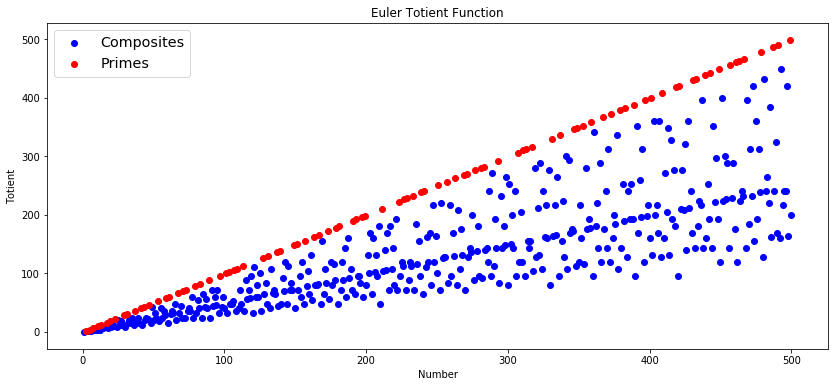

In [16]:
x_prime, x_comp = get_primes_composites(500)

y_prime = np.array([totient(x_prime[i]) for i in range(0, len(x_prime))])
y_comp = np.array([totient(x_comp[i]) for i in range(0, len(x_comp))])

plt.figure(figsize=(14, 6))
plt.scatter(x_comp, y_comp, color="blue", label="Composites")
plt.scatter(x_prime, y_prime, color="red", label="Primes")
plt.title("Euler Totient Function")
plt.ylabel("Totient")
plt.xlabel("Number")
plt.legend(fontsize="x-large")
plt.show()

Below is also an Euler Totient graph but this time it is calculated with compiled code and on multiple threads thus using all CPU's. This means more numbers can be shown. 

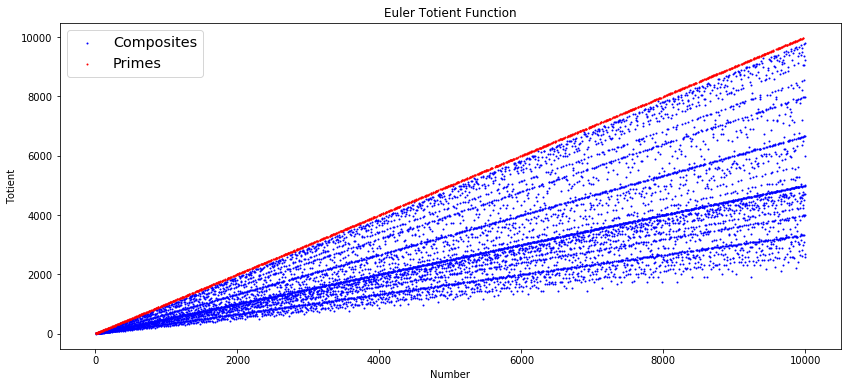

In [19]:
x_prime, x_comp = get_primes_composites(10000, is_prime_FUN=isprime_basic_fast)


y_prime = totient_fast_ufunc_par(x_prime)
y_comp = totient_fast_ufunc_par(x_comp)

plt.figure(figsize=(14, 6))
plt.scatter(x_comp, y_comp, color="blue", label="Composites", s = 1)
plt.scatter(x_prime, y_prime, color="red", label="Primes", s = 1)
plt.title("Euler Totient Function")
plt.ylabel("Totient")
plt.xlabel("Number")
plt.legend(fontsize="x-large")
plt.show()

### Note, forms of private key

If the private key is of the format $(p,q)$ where $N=pq$ given the public key $(N,e)$, the private key can be written in the format $(N,f)$ where $fe \equiv 1 \mod{\phi(N)}$ by the following code

In [10]:
def convert_to_N_f(prime_private_key, public_key):
    '''inputs private key of form two primes and public key
    outputs the new private key of form(N,f)'''
    p = prime_private_key["p"]
    q = prime_private_key["q"]
    N = public_key["N"]
    e = public_key["e"]

    if p*q != N:
        return "The private key does not work with public key"

    phi_N = (p-1)*(q-1)
    f = modular_inverse(e, phi_N)
    new_private_key = {"N": N, "f": f}
    return new_private_key

In [11]:
# Tests
prime_private_key = {"p": 41, "q": 61}
public_key = {"N": 2501, "e": 7}
private_key = convert_to_N_f(prime_private_key, public_key)
assert private_key == {"N": 2501, "f": 343}

## Examples of RSA Signature

### Example 1, no intruder

Bob wants to know the message he has been sent is from Alice. Therefore, Alice needs to generate private and public keys, sign the message. When Bob receives the message he has to verify the message is from Alice.

In [12]:
message = "Hello Bob my freind"
# Generate keys with 512 bit primes
private_key, public_key = Generation(512)

# Alice needs to sign message
s = Sign(message, private_key)

# s and message are sent to Bob
# Bob should also have access to the public key
# Bob will now verify Alice sent the message
Verification = Verify(message, s, public_key)
Verification

1

As can be seen the verification process passed so Bob knows Alice sent the message.

Sometimes with very small probability the prime generator will produce a composite number. However, this is fine as then the message will fail the verification process and then the signature process happens again.

### Example 2, intruder Dave

Bob wants to know the message he has been sent is from Alice. And that Dave has not captured and changed the message. Same as before  Alice needs to generate private and public keys, sign the message. When Bob receives the message he has to verify the message is from Alice. If the message fails verification Dave has changed the message. 

In [13]:
message = "Hello Bob my freind"
# Generate keys with 512 bit primes
private_key, public_key = Generation(512)

# Alice needs to sign message
s = Sign(message, private_key)

# s and message are sent to Bob
# Bob should also have access to the public key

# Dave intercepts the message and changes it
message = "I declare war on Bob"
# Dave sends new message to Bob

# Bob will now verify Alice sent the message
Verification = Verify(message, s, public_key)
Verification

0

The verification failed this means Bob knows that someone has intercepted and changed the message. 

### Example 3, 6 bit primes with tests and calculations

Let the message be hashed to $h$ where $h=15$, we will use 6 bit primes $p=41$ and $q=61$ so we get $N=2501$, we will use the fact that the Euler's totient function is multiplicative and $\phi{prime} = prime - 1$.
>$\phi{2501} = \phi{41}\phi{61} = 40*60 = 2400$

In [14]:
assert totient(2501) == 2400

We will select $e=7$ as $gcd(7,2400)=1$

calc by hand show working
if test then we get all pass

In [15]:
assert choose_e(2400) == 7

We need to solve for f
>\begin{align*}
ef &\equiv 1 \mod{\phi{N}}\\
7f &\equiv 1 \mod{2400}\\
f &= 343
\end{align*}

In [16]:
assert modular_inverse(7, 2400) == 343

Therefore, we get private key $(N=2501, f=343)$ and public key $(N=2501, e=7)$

In [17]:
private_key = {"N": 2501, "f": 343}
public_key = {"N": 2501, "e": 7}
message = 15

We need to sign the message, the signature $s$
>\begin{align*}
s &\equiv h^f \mod{N}\\
s &\equiv 15^{343} \mod{2501}\\
s &= 1053
\end{align*}

In [18]:
s = Sign(message, private_key)
assert s == 1053

The message and signature are sent off to the person, the person will verify the message by checking if their $h\prime = h$.

Let us consider the case where the message is not changed.

>\begin{align*}
h &\equiv s^e \pmod{N}\\
h &\equiv 1053^{7} \pmod{2501}\\
h &= 15
\end{align*}

So since $h\prime = h$ the message will be verified.

In [19]:
assert Verify(message, s, public_key) == 1

This time the same message is sent but a middle man intercepts the message and changes it. Let the new message be hashed to $h\prime=16$. Therefore, $h\prime \neq h$.


In [20]:
message = 16
assert Verify(message, s, public_key) == 0

The middle man will struggle to forge $s$ as they will struggle to find $f$ as they know $e$ and $N$ but only knowing that information makes solving $ef \equiv 1 \mod{\phi{N}}$ for $f$ difficult for large $N$ as $\phi{N}$ takes a long time to calculate.

## Problems with the Plain RSA signature

The Plain RSA signature is the same as the RSA-FDH signature but without the hash function $H$. This means only integers in $\{1,2,...,N-1\}$ can be sent as the message. With this signature there are a few forms of attacks.

### A no control of message attack,

This attack only requires the public key $(N,e)$, it works as follows. The attacker uniformly picks a signature $s$ where $s\in\{1,2,3,...,N-1\}$. Then calculates the message $h$ where 
>$h \equiv s^e \mod{N}$

Therefore, the message $h$ has a valid signature $s$, this is a forgery as no signatures were signed by the owner of the public key. However, the attacker has no control over the messages $h$ that get forged.

If this attack is repeated multiple times for different values of the signature $s$ then the attacker can pick a forged message which suits their needs.

### Forging a signature on an arbitary message

Say the attacker wants to forge a message $h\in\{1,2,3,...,N-1\}$ with respect to the public key $(N,e)$, then the attacker picks  $h_1,h_2\in\{1,2,3,...,N-1\}$ which is different from $h$ with
> $h \equiv h_1h_2\mod{N}$

The attacker then needs to obtain valid signatures $s_1, s_2$ for $h_1, h_2$. Then we have $s \equiv s_1s_2 \mod{N}$ is a valid signature for $h$. This is because
>$s^e \equiv (s_1s_2)^e \equiv (h_{1}^{f}h_{2}^{f})^e \equiv h_1^{fe}h_2^{fe} \equiv h_1h_2 \equiv h \mod{N}$

where $f$ is part of the private key, but isn't needed for this to work.

This may not seem devastating but it is dangerous to make assumptions about what messages the signer may or may not be willing to sign.

Additionally, multiple valid signatures $\textbf{s} = \{s_1, s_2, ..., s_q\}$ and their corresponding messages $\textbf{h} = \{h_1,h_2,...,h_q\}$ can be captured. By using the same principle as above the attacker can obtain a valid signature on any of the $2^q-q$ other messages by taking products of the subset $\textbf{h}$.

Furthermore, one example of getting signatures and messages is when a client wants to connect to a server. If a client uses a signature scheme to authenticate with the server and this is done by the client signing a random message sent by the server. It is easy for a malicious server to ask for a certain message to be signed.

## Hash Function

Let $m$ be a string message and $h$ be a hashed message such that $H(m) = h$

This means to prevent these attacks the hash function $H$ must have certain properties.
+ $H$ must be hard to invert, this will prevent the "no control of message attack". As for each valid signature that is forged it is difficult to find the string message $m$ which corresponds to the hashed message $h$

+ $H$ must not have multiplicative relations, that means it is hard to find three messages $m,m_1,m_2$ such that $H(m) = H(m_1)H(m_2)$. This should prevent the "forgery of an arbitrary message".

+ It must be hard to find collisions for $H$. Since if $H(m_1)=H(m_2)$, then $m_1$ and $m_2$ have the same signature, this means forgery of a non signed message is trivial.


# Diffie-Hellman Protocol

## Ronan Part

In [45]:
def sgrandprime(n_bit, t):  # Talk about why we use a prime here, its because using a Prime allows for many more potential Secret
    # Keys when modulo a prime, Also SOphie Germain prime avoids complications with certain primes because p-1 is composite, so
    # The multiplicative group has order p-1, which is mad as it makes it easy to crack
    while True:
        p = random_prime(n_bit-1, t, trails=5000) #-1 as 2*p + 1 needs to be n_bit prime
        if is_prime_miller_rabin((2*p)+1, t=40):
            return p, (2*p)+1


Publicprimes = sgrandprime(256, 40)

In [46]:
#Range test
test_prime = sgrandprime(10,40)[1]
assert test_prime<2**10
assert test_prime>=2**(10-1)

In [47]:
def safe_primitive_root(Publicprimes):
    q = Publicprimes[1]
    p = Publicprimes[0]
    b = 2
    primitive = False
    while not primitive:
        if b % q == 1 or (b*b) % q == 1 or pow(b, p, q) == 1:
            b += 1
            continue
        else:
            primitive = True
    return b


pr = safe_primitive_root(Publicprimes)
pr

2

In [48]:
def Private_keys(n, n_bit = 256):
    keys = []
    for i in range(0, n):
        keys.append(2**(n_bit -1) + ran.SystemRandom().getrandbits((n_bit -1)))
    return keys


keys = Private_keys(2)

Alice_private = keys[0]
Bob_private = keys[1]


def Public_Keys(primiroot, Privates, Prime):
    n = len(Privates)
    Publics = []
    for i in range(0, n):
        Publics.append(pow(primiroot, Privates[i], Prime))
    return Publics


Publics = Public_Keys(pr, keys, Publicprimes[1])

Alice_public = Publics[0]
Bob_public = Publics[1]


def Secret_key(publics, privates, generator):
    n = len(publics)
    publicuse = publics
    for m in range(0, n-1):
        Temp = []
        for i in range(0, n):
            Temp.append(pow(publicuse[(i-1) % n], privates[i], generator))
        for j in range(0, n):
            publicuse[j] = Temp[j]
    Final = Temp
    return Final


Secret_key(Publics, keys, Publicprimes[1])

[27458413833330209910067655602030970328231646874965249779207146680339164682005,
 27458413833330209910067655602030970328231646874965249779207146680339164682005]

In [49]:
# Three parties
threekeys = Private_keys(3)
Three_Alice_private = threekeys[0]
Three_Bob_private = threekeys[1]
Three_Charlie_private = threekeys[2]

Three_Public = Public_Keys(pr, threekeys, Publicprimes[1])

Three_Alice_public = Three_Public[0]
Three_Bob_public = Three_Public[1]
Three_Charlie_public = Three_Public[2]

Secret_key(Three_Public, threekeys, Publicprimes[1])

[40243474632964431943122377413471674922046232043245292967670542318280490487278,
 40243474632964431943122377413471674922046232043245292967670542318280490487278,
 40243474632964431943122377413471674922046232043245292967670542318280490487278]

## Mark Part

Solving Discrete Logarithm Problem Using Brute Force

In [26]:
Private_keys(1)

[91191854821211850519475909873254176559251166530888189669953193890892278040696]

In [33]:
def discrete_logarithm_brute(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """

    b = 1
    while True:
        if pow(a, b, N) == z:
            return b
        b += 1


def discrete_logarithm_brute_better(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method 

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """
    b = 1
    a_new = a
    while True:
        if a_new == z:
            return b
        a_new = (a_new*a) % N
        b += 1

@numba.jit('int64(int64,int64,int64)', nopython = True)
def discrete_logarithm_brute_better_fast(a, N, z):
    """Solves the discrete logarithm problem

    Solves z = a^b mod(N) for b, by using a brute force method, uses a complied version

    Parameters
    ----------
    a : int
    N : int
    z : int

    Returns
    -------
    int
        Solves z = a^b mod(N) for b,
    """
    b = 1
    a_new = a
    while True:
        if a_new == z:
            return b
        a_new = (a_new*a) % N
        b += 1


In [34]:
# Tests
assert discrete_logarithm_brute(15, 2342, 167) == 37
assert discrete_logarithm_brute(5, 352, 133) == 25
assert discrete_logarithm_brute(3452, 123456, 39104) == 543

# Tests
assert discrete_logarithm_brute_better(15, 2342, 167) == 37
assert discrete_logarithm_brute_better(5, 352, 133) == 25
assert discrete_logarithm_brute_better(3452, 123456, 39104) == 543

# Tests
assert discrete_logarithm_brute_better_fast(15, 2342, 167) == 37
assert discrete_logarithm_brute_better_fast(5, 352, 133) == 25
assert discrete_logarithm_brute_better_fast(3452, 123456, 39104) == 543

In [35]:
%timeit discrete_logarithm_brute(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better(3452, 123456, 39104)
%timeit discrete_logarithm_brute_better_fast(3452, 123456, 39104)

641 µs ± 2.85 µs per loop (mean ± std. dev. of 7 runs, 1000 loops each)
58.5 µs ± 304 ns per loop (mean ± std. dev. of 7 runs, 10000 loops each)
5.62 µs ± 36.3 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [29]:
#discrete_logarithm_brute(2,4,3)
#Will run forever

In [75]:
def gen_public_key(n_bit):
    """generates public information

    Generates then calculates public information

    Parameters
    ----------
    n_bit : int
        The size of the p prime wanted

    Returns
    -------
    dict
        The public information
        A : solution to g^a mod(p)
        g : primitive root
        p : large n_bit prime

    """
    q, p = sgrandprime(n_bit, 40)
    g = safe_primitive_root([q, p])
    a = Private_keys(1, n_bit)[0]
    A = pow(g, a, p)
    #print("a: " + str(a) + " A: " + str(A) + " g: " + str(g) + " p: " + str(p))
    return {"A": A, "g": g, "p": p}


def time_func(Func, num_samples, Func_parameters = [[]]):
    """Times the function

    Parameters
    ----------
    Func : function
        Function that is being timed 
    num_samples : int
        Number of times Func will run
    Func_parameters : 2D array
        Each array in 2D array are the parameters of the Function Func, if num_samples
        greater than number of arrays then it will loop over
    
    Returns
    -------
    tuple
        mean_time,
        std_time
        
        
    Examples
    --------
    time_func(decompose, 4, [[3226322291321]])   
    #will time decompose function 4 times with parameter 3226322291321
       
    time_func(decompose, 3, [[3304575252941], [1954377239027], [2964234252593]])   
    #will time decompose function 3 times with a differenc parameter each time
    
    
    """
    times = np.zeros(num_samples)
    loopover = len(Func_parameters)
    for i in range(num_samples):
        temp_start_time = time.time()
        Func(*Func_parameters[i%loopover])
        temp_finish_time = time.time()
        times[i] = (temp_finish_time - temp_start_time)
    
    return times.mean(), times.std()
    

In [76]:
def format_input_parameters(public_keys, my_order = ["g", "p", "A"]):
    """Formats parameters for the function


    Parameters
    ----------
    public_keys : array of dict

    my_oreder : array of str
        What order is wanted for the output

    Returns
    -------
    2D array
        The parameters for the funciton

    """

    formated_public_keys = []
    
    for public_key in public_keys:
        temp_public_key = []
        for key in my_order:
            temp_public_key.append(public_key[key])
        formated_public_keys.append(temp_public_key)

    return formated_public_keys



In [77]:
# Test format_input_parameters
input_public_keys = [{"A": 307, "g": 5, "p": 863},
                     {"g": 5, "A": 844, "p": 983},
                     {"p": 563, "g": 2, "A": 83}]
expected_format = [[5, 863, 307],
                   [5, 983, 844],
                   [2, 563, 83]]
assert format_input_parameters(input_public_keys) == expected_format

In [79]:
start = 6
stop = 28
num_samples = 10

mean_times = []
std_times = []

for n_bit in range(start, stop):
    public_keys = [gen_public_key(n_bit) for i in range(num_samples)]

    input_parameters = format_input_parameters(public_keys)
    temp_mean, temp_std = time_func(
        discrete_logarithm_brute_better_fast, num_samples, input_parameters)
    mean_times.append(temp_mean)
    std_times.append(temp_std)

print("discrete_logarithm_brute(g, p, A)")

my_time_data = {"Mean time": mean_times,
                "Std time": std_times}
time_data_frame = pd.DataFrame(data=my_time_data)
time_data_frame.index = range(start, stop)
time_data_frame.index.name = "bit size of p and a"

print(time_data_frame)

discrete_logarithm_brute(g, p, A)
                     Mean time  Std time
bit size of p and a                     
6                     0.000000  0.000000
7                     0.000000  0.000000
8                     0.000000  0.000000
9                     0.000000  0.000000
10                    0.000000  0.000000
11                    0.000000  0.000000
12                    0.000100  0.000299
13                    0.000100  0.000299
14                    0.000097  0.000290
15                    0.000200  0.000399
16                    0.000302  0.000461
17                    0.000499  0.000499
18                    0.001696  0.000456
19                    0.001696  0.001002
20                    0.004787  0.002673
21                    0.005687  0.006262
22                    0.020046  0.010835
23                    0.027526  0.019898
24                    0.033314  0.034925
25                    0.119284  0.087941
26                    0.326727  0.170783
27                    0

In [34]:
mean_times

[0.0,
 0.0,
 0.0001994609832763672,
 0.0002991676330566406,
 0.0004972934722900391,
 0.0008975744247436523,
 0.0012965440750122071,
 0.0030931711196899416,
 0.007782506942749024,
 0.015558362007141113,
 0.04278972148895264,
 0.10433056354522705,
 0.21462621688842773,
 0.44092133045196535]

In [35]:
std_times

[0.0,
 0.0,
 0.0005983829498291016,
 0.0004573691277150501,
 0.0004973077099892887,
 0.0008284811321897422,
 0.0010023122932317126,
 0.0024997470479998923,
 0.005781693053138425,
 0.013671117499960264,
 0.030443842034209023,
 0.04650373618723107,
 0.13709305444972497,
 0.30028754223397913]

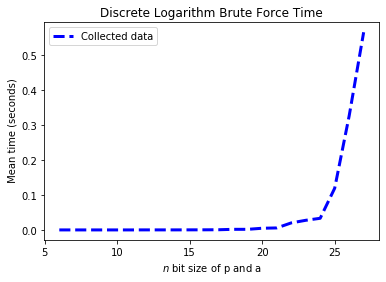

In [80]:
# Silly example data
#bp_x = np.linspace(0, 2*np.pi, num=40, endpoint=True)
#bp_y = np.sin(bp_x)


# Make the plot
plt.plot(range(start,stop),mean_times, linewidth=3, linestyle="--",
         color="blue", label=r"Collected data")
plt.xlabel(r"$n$ bit size of p and a")
plt.ylabel(r" Mean time (seconds)")
plt.title(r"Discrete Logarithm Brute Force Time")
#plt.xlim(0, 2*np.pi)
#plt.ylim(-1.1, 1.1)
plt.legend(loc="upper left")
plt.show()



In [37]:
q, p = sgrandprime(10, 40)
g = safe_primitive_root([q, p])
a = Private_keys(1, 10)[0]
print(a)
print(p)
A = pow(g, a, p)
print(A)
# A = g^a mod(p)

discrete_logarithm_brute(g, p, A)

632
887
435


632

In [41]:
# File save
# Will be frozen so can't run when montoring
start = 6
stop = 70
num_samples = 25


file_name = "BruteForceDiscreteLogData.csv"


for n_bit in range(start, stop):
    public_keys = [gen_public_key(n_bit) for i in range(num_samples)]

    input_parameters = format_input_parameters(public_keys)
    temp_mean, temp_std = time_func(
        discrete_logarithm_brute, num_samples, input_parameters)

    string_to_append = str(n_bit) + ", "
    string_to_append += str(temp_mean) + ", "
    string_to_append += str(temp_std) + ", "
    string_to_append += str(num_samples) + "\n"
    brute_force_file = open(file_name, "a")
    brute_force_file.write(string_to_append)
    brute_force_file.close()

KeyboardInterrupt: 